In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
def cor(x,y):
    xa = x - np.nanmean(x)
    ya = y - np.nanmean(y)
    return np.nansum(xa*ya)/np.sqrt(np.nansum(xa**2)*np.nansum(ya**2))

In [3]:
n34_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34/dods'
n34_ds = xr.open_dataset(n34_url)
n34 = n34_ds.n34
nmonths = len(n34)
n34a = n34.groupby('T.month') - n34.groupby('T.month').mean()

### Data set description  
1. variable: Nino 3.4 anomaly

2. resolution: monthly

3. extent: 1980--2020

### Problem 

Understand how well periodic AR2 models Nino 3.4.

### Methodology
Define a periodic AR2 model:
$$ X_t = \phi_1(t) X_{t-1} + \phi_2(t) X_{t-2} + W_t $$

with $\phi_1(t + 12) = \phi_1(t), \phi_2(t + 12) = \phi_2(t)$ and periodic Gaussian white noise $W_t \sim N(0, \sigma_t^2), \sigma_t = \sigma_{t+12}$.

Define the variance vector $v$ by

$$ v_t = 
\begin{bmatrix}
\text{var} [ X_t ] \\
\text{var} [ X_{t+1} ] \\
\vdots \\
\text{var} [ X_{t+10} ] \\
\text{var} [ X_{t+11} ] \\
\end{bmatrix}
$$

A. Construct an equation $A_tv_t = b$ to solve $v_t$ by finding the matrix $A_t$ and the vector $b$.

B. Fit a periodic AR2 model to Nino 3.4 dataset, then solve $v$ numerically. Plot solved $v$ and the variance of Nino 3.4 by month.

C. Derive a formula for $\text{cor} [X_t, X_{t+\tau}]$, $\tau > 0$. Plot it for $t = 0, ... 11$ and $\tau = 1, ..., 12$ with the parameters of the fitted periodic AR2 model.

### Preliminary result

#### data set plot

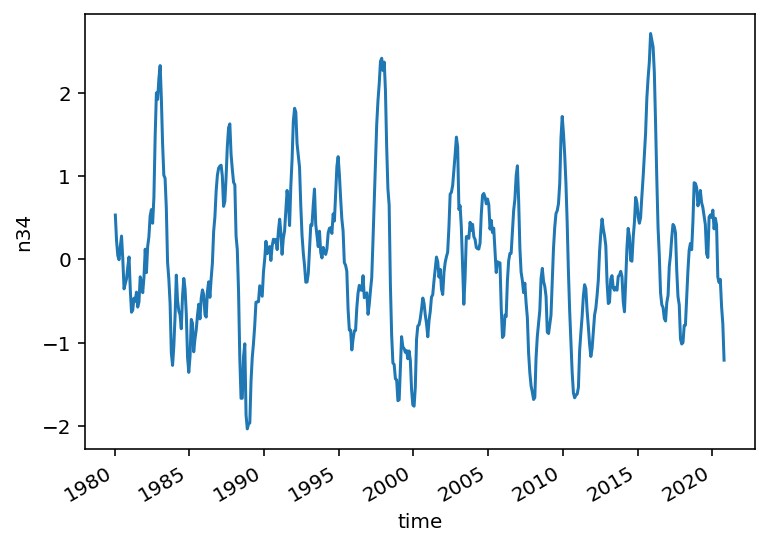

In [6]:
n34a.plot();

#### some results from periodic AR1

In [7]:
from numpy.linalg import inv

# t: index of n34a 
y = n34a[1:].values
N = len(y)

t_first = 1
mt = np.arange(1, N + t_first)/12.*2*np.pi

X = np.empty((N,4)) + np.nan
X[:, 0] = 1.
X[:, 1] = n34a[0:-1]
X[:, 2] = n34a[0:-1] * np.sin(mt)
X[:, 3] = n34a[0:-1] * np.cos(mt)

beta = inv(X.T@X)@X.T@y
yhat = X@beta
R = y - yhat

In [11]:
R = n34a[1:].copy(data = R)
sigma_wt = R.groupby('T.month').std(ddof = 2)

In [12]:
def phi(t):
    mt = 2*np.pi*t/12.
    return beta[1] + beta[2:] @ np.array([np.sin(mt), np.cos(mt)])

In [13]:
A_0 = np.diag(phi(np.arange(1, 13)) ** 2)
A_0 = A_0 - np.diag(np.ones(11), k = 1)
A_0[-1, 0] = -1

In [22]:
b = - (sigma_wt.roll(month = -1).values) ** 2

In [23]:
v = inv(A_0) @ b

In [24]:
var = []
for i in range(0, 12):
    var.append(np.std(n34a[i::12].values, ddof = 1) ** 2)

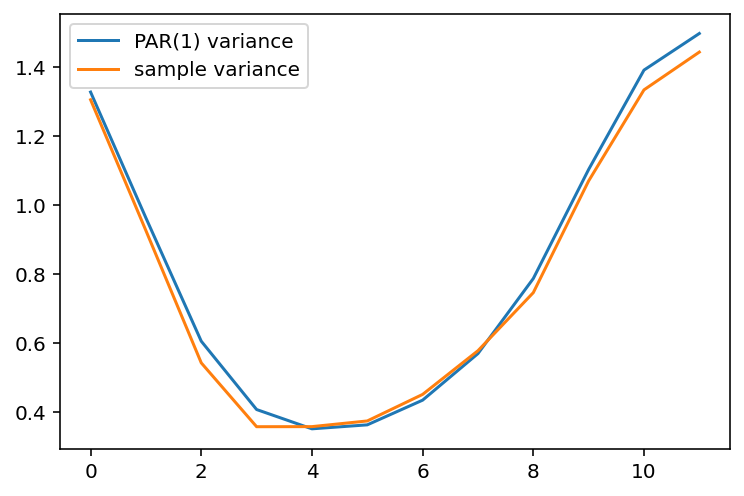

In [26]:
plt.plot(v, label = 'PAR(1) variance')
plt.plot(var, label = 'sample variance')
plt.legend();

In [27]:
T = np.arange(0, 12)
Tau = np.arange(1, 13)
Cor = np.zeros((12, 12))

for ii in range(12):
    for jj in range(12):
        tau = Tau[ii]
        t = T[jj]
        var_x_t = v[t]
        var_x_t_tau = v[(t+tau)%12]
        phis = phi(np.arange(t + 1, t + tau + 1))
        cor = np.prod(phis) * np.sqrt(var_x_t / var_x_t_tau)
        Cor[ii, jj] = cor

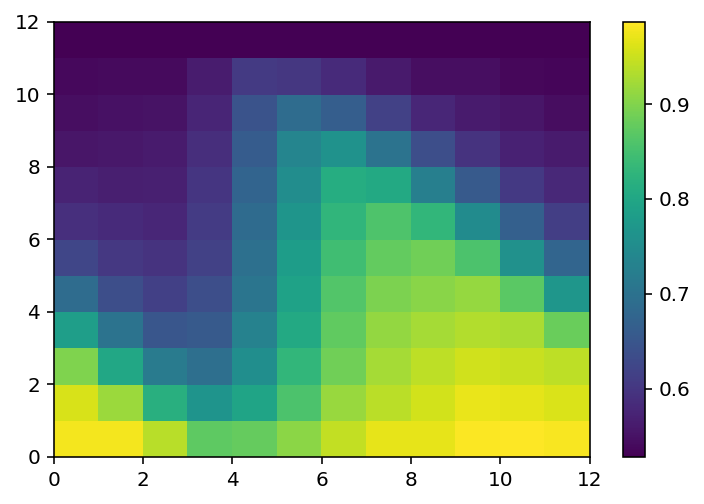

In [28]:
g = plt.pcolormesh(Cor)
plt.colorbar(g)
plt.show()

In [29]:
np.max(Cor)

0.9867140563899034